# Exploratory Analysis of Reddit World News

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
import os
import genism
from scipy import spatial
import logging
from pprint import pprint  # pretty-printer
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

In [4]:
df=pd.read_csv('reddit_worldnews.csv')
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [5]:
df.shape

(509236, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null int64
date_created    509236 non-null object
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
subreddit       509236 non-null object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [7]:
df.date_created = pd.to_datetime(df.date_created)

In [8]:
print('Date created ranges from', df['date_created'].min(), 'to', df['date_created'].max(), '.')

Date created ranges from 2008-01-25 00:00:00 to 2016-11-22 00:00:00 .


In [9]:
df_1 = df[['date_created', 'up_votes', 'down_votes']]

In [10]:
df_1.date_created=[time.strftime('%Y') for time in df_1.date_created]

In [11]:
df_size=df_1.groupby('date_created').size().to_frame()
df_size=df_size.rename(columns={0:'count'})

## News count by year

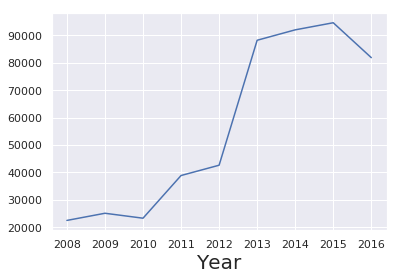

In [12]:
import matplotlib.pyplot as plt
plt.plot(list(df_size.index),df_size['count'])
plt.xlabel('Year', fontsize=20)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

### We can see that from 2012 to 2013, the amount of news around the world in Reddit increases significantly. 

In [13]:
df_2 = df[['date_created', 'up_votes', 'down_votes']]
df_2.date_created=[time.strftime('%b') for time in df_2.date_created]
df_size2=df_2.groupby('date_created').size().to_frame()
df_size2=df_size2.rename(columns={0:'count'})

In [14]:
df_size2=df_size2.sort_values(by='count')

## News count by month

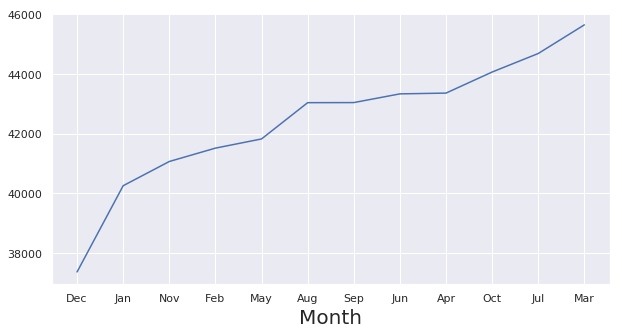

In [15]:
import matplotlib.pyplot as plt
plt.plot(list(df_size2.index),df_size2['count'])
plt.xlabel('Month', fontsize=20)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [16]:
import spacy
#spacy.load('en')
#from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import re
import os
def cleanContent(contents):
    contents_new=[]
    contents_list = contents.tolist()
    tweets_list_new=[]
    for tweet in contents_list:
        if 'http' in tweet:
            index = tweet.rfind('http')
            tweet = tweet.replace(tweet[index:], '')
        tweets_list_new.append(tweet)
    for content in tweets_list_new:
        # Convert to lowercase
        content_low=content.lower()
        # Remove punctuation and any other non-alphabet characters
        content_low_pnt = re.sub(r'[^\w\s]', '', content_low)
        content_low_pnt = content_low_pnt.replace(os.linesep, " ")
        content_low_pnt = content_low_pnt.replace("\t", " ")
        content_low_pnt_alpha = re.sub('[^A-Za-z\s]', '', content_low_pnt)
        # Remove stopwords
        words=content_low_pnt_alpha.split()
        no_stop_words=[word for word in words if word not in STOP_WORDS]
        content=' '.join(no_stop_words)
        contents_new.append(content)
    return contents_new

In [17]:
df_text=df.copy()
df_text['title']=cleanContent(df_text['title'])

In [18]:
titles=""
for title in df_text['title']:
    titles += title

## WordCloud of words in news titles

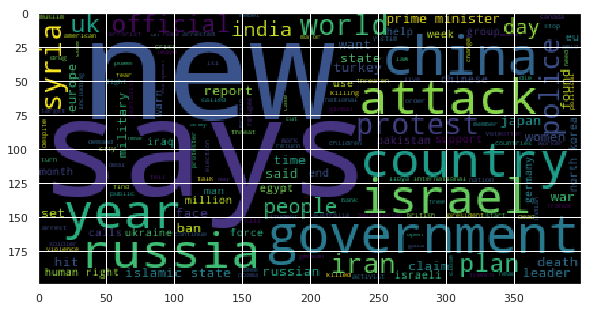

In [19]:
from wordcloud import WordCloud
wordcloud=WordCloud().generate(titles)
plt.imshow(wordcloud)
plt.show()

## Upvotes

In [20]:
df.up_votes.describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [21]:
df.up_votes.median()

5.0

In [22]:
df.up_votes.mean()

112.23628337352426

Text(0, 0.5, 'Logscale frequency')

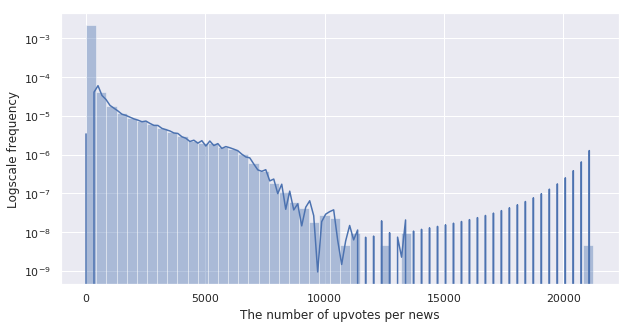

In [23]:
import seaborn as sns
ax=sns.distplot(df.up_votes, kde=True)
ax.set_yscale('log')
ax.set_xlabel('The number of upvotes per news')
ax.set_ylabel('Logscale frequency')

### The distribution of the number of upvotes per news is greatly right skewed.

In [24]:
df_votes=df.copy()
df_votes=df_votes[df_votes.up_votes>=df_votes.up_votes.mean()]
len(df_votes)

47902

In [25]:
df_votes.title=cleanContent(df_votes.title)
titles1=""
for title in df_votes['title']:
    titles1 += title

## The WordCloud of news titles that have more than average number of upvotes

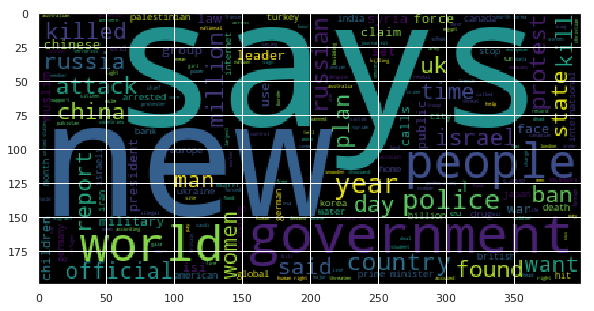

In [26]:
from wordcloud import WordCloud
wordcloud=WordCloud().generate(titles1)
plt.imshow(wordcloud)
plt.show()

### As we compare it to the wordcloud above it, we can see that most frequent words still largely apply. 'china' looks smaller here.

In [27]:
author_counts=df_votes['author'].value_counts().to_frame().rename(columns={'author':'counts'})
author_counts.head()

,counts
maxwellhill,1494
anutensil,1353
Libertatea,576
DoremusJessup,505
davidreiss666,434


Text(0, 0.5, 'Frequency')

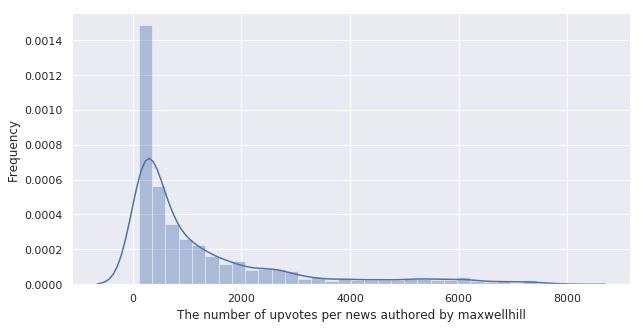

In [28]:
import seaborn as sns
ax=sns.distplot(df_votes[df_votes.author=='maxwellhill']['up_votes'], kde=True)
ax.set_xlabel('The number of upvotes per news authored by maxwellhill')
ax.set_ylabel('Frequency')

In [29]:
df_votes1=df.copy()
df_votes1=df_votes1[df_votes1.up_votes==1]
len(df_votes1)

46619

In [30]:
df_votes1.title=cleanContent(df_votes1.title)
titles2=""
for title in df_votes1['title']:
    titles2 += title

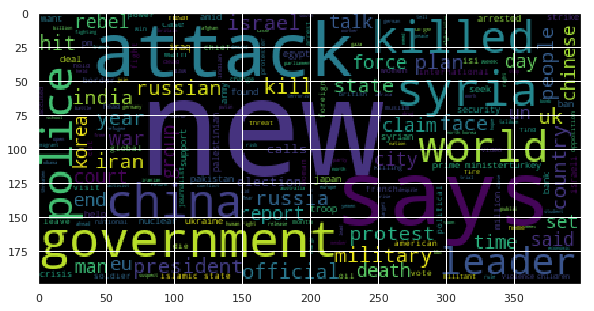

In [31]:
from wordcloud import WordCloud
wordcloud=WordCloud().generate(titles2)
plt.imshow(wordcloud)
plt.show()

In [32]:
df.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

In [33]:
df_title2=df.copy()
df_title2=df_title2[df_title2['over_18']==True]
df_title2.title=cleanContent(df_title2.title)
titles3=""
for title in df_title2['title']:
    titles3 += title

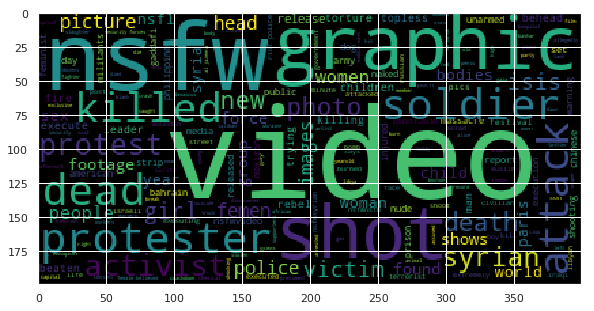

In [34]:
from wordcloud import WordCloud
wordcloud=WordCloud().generate(titles3)
plt.imshow(wordcloud)
plt.show()

In [35]:
import random
df_sample=df.sample(n=5000, random_state=1)
df_sample.to_csv('reddit_worldnews_sample.csv')

## Sentiment Analysis

In [36]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [38]:
from pprint import pprint  # pretty-printer
from collections import defaultdict

documents=list(df.title)

stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist] for document in documents]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [39]:
texts[:5]

[['scores', 'killed', 'pakistan', 'clashes'],
 ['japan', 'resumes', 'refuelling', 'mission'],
 ['us', 'presses', 'egypt', 'on', 'gaza', 'border'],
 ['jump-start', 'economy:', 'give', 'health', 'care', 'all'],
 ['council', 'europe', 'bashes', 'terror', 'blacklist']]

In [40]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

2019-05-04 19:00:28,590 : INFO : 'pattern' package not found; tag filters are not available for English
2019-05-04 19:00:28,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-05-04 19:00:28,753 : INFO : adding document #10000 to Dictionary(17216 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)
2019-05-04 19:00:28,906 : INFO : adding document #20000 to Dictionary(24922 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)
2019-05-04 19:00:29,110 : INFO : adding document #30000 to Dictionary(31111 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)
2019-05-04 19:00:29,299 : INFO : adding document #40000 to Dictionary(36609 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)
2019-05-04 19:00:29,496 : INFO : adding document #50000 to Dictionary(42570 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)
2019-05-04 19:00:29,692 : INFO : adding document #60000 to Dictionary

Dictionary(93893 unique tokens: ['clashes', 'killed', 'pakistan', 'scores', 'japan']...)


In [41]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('/tmp/deerwester.mm', corpus)  # store to disk, for later use

2019-05-04 19:00:47,481 : INFO : storing corpus in Matrix Market format to /tmp/deerwester.mm
2019-05-04 19:00:47,484 : INFO : saving sparse matrix to /tmp/deerwester.mm
2019-05-04 19:00:47,485 : INFO : PROGRESS: saving document #0
2019-05-04 19:00:47,508 : INFO : PROGRESS: saving document #1000
2019-05-04 19:00:47,536 : INFO : PROGRESS: saving document #2000
2019-05-04 19:00:47,559 : INFO : PROGRESS: saving document #3000
2019-05-04 19:00:47,587 : INFO : PROGRESS: saving document #4000
2019-05-04 19:00:47,611 : INFO : PROGRESS: saving document #5000
2019-05-04 19:00:47,644 : INFO : PROGRESS: saving document #6000
2019-05-04 19:00:47,671 : INFO : PROGRESS: saving document #7000
2019-05-04 19:00:47,699 : INFO : PROGRESS: saving document #8000
2019-05-04 19:00:47,726 : INFO : PROGRESS: saving document #9000
2019-05-04 19:00:47,756 : INFO : PROGRESS: saving document #10000
2019-05-04 19:00:47,788 : INFO : PROGRESS: saving document #11000
2019-05-04 19:00:47,815 : INFO : PROGRESS: saving d

In [42]:
class MyCorpus(object):
    def __iter__(self):
        for line in open('mycorpus.txt'):
            # assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.lower().split())

In [43]:
corpus_memory_friendly = MyCorpus()  # doesn't load the corpus into memory!
print(corpus_memory_friendly)

In [44]:
from gensim import corpora
if (os.path.exists("/tmp/deerwester.dict")):
    dictionary = corpora.Dictionary.load('/tmp/deerwester.dict')
    corpus = corpora.MmCorpus('/tmp/deerwester.mm')
    print("Used files generated from first tutorial")
else:
    print("Please run first tutorial to generate data set")

2019-05-04 19:01:02,277 : INFO : loading Dictionary object from /tmp/deerwester.dict
2019-05-04 19:01:02,381 : INFO : loaded /tmp/deerwester.dict
2019-05-04 19:01:02,485 : INFO : loaded corpus index from /tmp/deerwester.mm.index
2019-05-04 19:01:02,488 : INFO : initializing cython corpus reader from /tmp/deerwester.mm
2019-05-04 19:01:02,490 : INFO : accepted corpus with 509236 documents, 93893 features, 5993696 non-zero entries


Used files generated from first tutorial


In [46]:
import gensim
models = gensim.models.Word2Vec(texts)

2019-05-04 19:02:10,525 : INFO : collecting all words and their counts
2019-05-04 19:02:10,529 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-04 19:02:10,580 : INFO : PROGRESS: at sentence #10000, processed 90544 words, keeping 17216 word types
2019-05-04 19:02:10,629 : INFO : PROGRESS: at sentence #20000, processed 183690 words, keeping 24922 word types
2019-05-04 19:02:10,700 : INFO : PROGRESS: at sentence #30000, processed 281642 words, keeping 31111 word types
2019-05-04 19:02:10,740 : INFO : PROGRESS: at sentence #40000, processed 387262 words, keeping 36609 word types
2019-05-04 19:02:10,812 : INFO : PROGRESS: at sentence #50000, processed 523700 words, keeping 42570 word types
2019-05-04 19:02:10,873 : INFO : PROGRESS: at sentence #60000, processed 654841 words, keeping 47110 word types
2019-05-04 19:02:10,926 : INFO : PROGRESS: at sentence #70000, processed 794061 words, keeping 51171 word types
2019-05-04 19:02:10,971 : INFO : PROGRESS: at s

## Identify similar words

In [49]:
models.most_similar("china", topn=10)

[('beijing', 0.7692674398422241),
 ('chinese', 0.7226839661598206),
 ('vietnam', 0.7114782333374023),
 ('china’s', 0.7106224894523621),
 ('china,', 0.6964410543441772),
 ('taiwan', 0.6765043139457703),
 ('japan', 0.6632295846939087),
 ('india', 0.6405718326568604),
 ('china.', 0.6281684041023254),
 ('china:', 0.6204382181167603)]

In [51]:
models.most_similar("new", topn=10)

[('latest', 0.45093458890914917),
 ('controversial', 0.4508498013019562),
 ('fresh', 0.4199826717376709),
 ('(new', 0.4154854416847229),
 ('equatorial', 0.39962828159332275),
 ('stricter', 0.3975641429424286),
 ('draft', 0.38997381925582886),
 ('tighter', 0.38722527027130127),
 ('times)', 0.3790339231491089),
 ('toughest', 0.37023791670799255)]

In [52]:
models.most_similar("government", topn=10)

[('govt', 0.750764787197113),
 ('government,', 0.7343209981918335),
 ('government.', 0.6551814675331116),
 ('government’s', 0.6196965575218201),
 ('govt.', 0.6018266677856445),
 ('cabinet', 0.5364360213279724),
 ('regime', 0.5333266854286194),
 ('coalition', 0.5155774354934692),
 ('legislation', 0.5074989795684814),
 ('constitution', 0.49840977787971497)]

In [54]:
models.most_similar("russia", topn=10)

[('russian', 0.7433468103408813),
 ('russia’s', 0.7172669172286987),
 ('moscow', 0.7073964476585388),
 ('russia,', 0.7044513821601868),
 ('putin', 0.6949900388717651),
 ('russia.', 0.6501691937446594),
 ('poland', 0.6400519609451294),
 ('russia:', 0.6373326778411865),
 ('turkey', 0.6230515241622925),
 ('lithuania', 0.6109845638275146)]

In [55]:
models.most_similar("porn", topn=10)

[('pornography', 0.8393072485923767),
 ('pornographic', 0.745589554309845),
 ('music', 0.7244936227798462),
 ('grindr', 0.7190013527870178),
 ('content', 0.7097147703170776),
 ('ads', 0.7056324481964111),
 ('wikipedia', 0.705200731754303),
 ('facebook', 0.7037116885185242),
 ('filter', 0.6928709149360657),
 ('facebook,', 0.6899778842926025)]

In [56]:
models.most_similar("trump", topn=10)

[('donald', 0.8510112762451172),
 ('trump’s', 0.7056031227111816),
 ('biden', 0.6923565864562988),
 ('clinton', 0.6670318841934204),
 ('trudeau', 0.6637316346168518),
 ('hillary', 0.6633999347686768),
 ('trump,', 0.6621276140213013),
 ('mccain', 0.6573306918144226),
 ('tsipras', 0.6480412483215332),
 ('merkel', 0.6392456293106079)]

In [58]:
models.most_similar("turkey", topn=10)

[('turkish', 0.7391510605812073),
 ('turkey,', 0.7049596309661865),
 ('egypt', 0.6831494569778442),
 ('bulgaria', 0.6778308153152466),
 ('hungary', 0.6670142412185669),
 ('lebanon', 0.6634544134140015),
 ('ankara', 0.6578640937805176),
 ('erdogan', 0.653704047203064),
 ('germany', 0.6446664333343506),
 ('jordan', 0.6360765695571899)]

In [59]:
models.most_similar("video", topn=10)

[('footage', 0.8706527948379517),
 ('photo', 0.758337140083313),
 ('videos', 0.7575719356536865),
 ('photos', 0.755079984664917),
 ('cctv', 0.7406094074249268),
 ('pictures', 0.7263796329498291),
 ('clip', 0.679892361164093),
 ('video.', 0.6753766536712646),
 ('graphic', 0.6708993315696716),
 ('video,', 0.6612422466278076)]

In [61]:
models.most_similar("day", topn=10)

[('day,', 0.759729266166687),
 ('day.', 0.7244173288345337),
 ('night', 0.682093620300293),
 ('minute', 0.6295664310455322),
 ('month', 0.6122779250144958),
 ('hour', 0.5723926424980164),
 ('eid', 0.561335563659668),
 ('anniversary', 0.5446943640708923),
 ('day:', 0.5414177775382996),
 ('square', 0.5406319499015808)]

## Identify biases in word embeddings

In [63]:
from scipy import spatial
def cosine_similarity(x, y):
    return(1 - spatial.distance.cosine(x, y))

In [65]:
vocab=list(models.wv.vocab.keys())

In [66]:
def wordsinScale(vocab,word1,word2):
    df_lists=[]
    for each in vocab:
        df_list=[cosine_similarity(models.wv[each], models.wv[word1]-models.wv[word2])]
        df_lists.append(df_list)
    pol_words_sim = pd.DataFrame(df_lists,index=vocab, columns=[word1+"-"+word2])
    return pol_words_sim

In [70]:
#russia:china
pol_words_sim=wordsinScale(vocab,"russia","china")

In [74]:
#russia
pol_words_sim.sort_values(by="russia-china",ascending=False).head(10)

,russia-china
russia,0.573008
russian,0.462900
"russia,",0.435748
assad:,0.421779
russia:,0.380538
turkmens,0.369558
rebels:,0.368751
"regime,",0.365760
russia’s,0.349054
regime,0.343170


In [75]:
#china
pol_words_sim.sort_values(by="russia-china",ascending=True).head(10)

,russia-china
chinese,-0.500601
china,-0.498135
china:,-0.449327
"china,",-0.437329
china’s,-0.410207
china.,-0.366985
indian,-0.362984
india:,-0.346805
cebu,-0.341361
amur,-0.339213


In [76]:
#real:fake
pol_words_sim=wordsinScale(vocab,"real","fake")

In [77]:
#real
pol_words_sim.sort_values(by="real-fake",ascending=False).head(10)

,real-fake
real,0.658542
democracy,0.620322
stability,0.586598
outcome,0.575046
current,0.575000
future,0.573961
prosperity,0.570603
"peace,",0.568899
"politics,",0.559811
democracy.,0.557161


In [78]:
#fake
pol_words_sim.sort_values(by="real-fake",ascending=True).head(10)

,real-fake
allegedly,-0.606080
sulfuric,-0.568774
belonging,-0.532614
fake,-0.522533
carrying,-0.512997
intercepted,-0.507638
mistakenly,-0.507263
suspected,-0.495544
illegally,-0.489054
containing,-0.489008


In [79]:
#attack:peace
pol_words_sim=wordsinScale(vocab,"attack","peace")

In [80]:
#attack
pol_words_sim.sort_values(by="attack-peace",ascending=False).head(10)

,attack-peace
attack,0.767934
attacks,0.653018
attack.,0.645530
attack:,0.638259
"attack,",0.582659
raid,0.557642
blast,0.557194
bombings,0.555556
rampage,0.540581
bombing,0.535549


In [81]:
#peace
pol_words_sim.sort_values(by="attack-peace",ascending=True).head(10)

,attack-peace
peace,-0.639097
reconciliation,-0.541863
"peace,",-0.507064
trans-pacific,-0.485515
two-state,-0.460017
free-trade,-0.457963
solution,-0.455819
minsk,-0.443220
"reconciliation,",-0.442951
creditors,-0.441463


In [85]:
#trump:hillary
pol_words_sim=wordsinScale(vocab,"trump","hillary")

In [86]:
#trump
pol_words_sim.sort_values(by="trump-hillary",ascending=False).head(10)

,trump-hillary
trump,0.663741
catalonia,0.578396
independence,0.556300
independence:,0.531619
brexit,0.505051
iceland,0.503562
donald,0.491120
scottish,0.490520
secession,0.489210
islanders,0.487828


In [87]:
#hillary
pol_words_sim.sort_values(by="trump-hillary",ascending=True).head(10)

,trump-hillary
executing,-0.485061
amputations,-0.451728
committing,-0.446015
executes,-0.445788
medecins,-0.444903
included,-0.444351
"killings,",-0.442397
executed,-0.431379
idf:,-0.422398
"torture,",-0.418854


In [105]:
info_vocab=[word[0] for word in models.most_similar("trump", topn=100)]

In [110]:
pol_words_sim_2d=pd.concat([wordsinScale(info_vocab,"female","male"),wordsinScale(info_vocab,"sexist","feminist")],axis=1)
pol_words_sim_2d.head()

,female-male,sexist-feminist
donald,0.011532,0.409264
trump’s,0.029537,0.280586
biden,0.097101,0.315769
clinton,0.098488,0.352211
trudeau,0.188220,0.409276


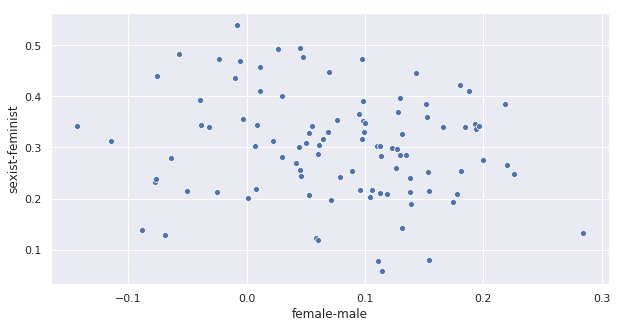

In [111]:
import seaborn as sns
sns.scatterplot(x='female-male', y='sexist-feminist', data=pol_words_sim_2d)

### We can see that, the top 100 similar words to the word 'trump' are leaning male in 'female-male' scale, and leaning 'sexist' in 'sexist-feminist' scale.

## Word Clustering

In [117]:
# take an example of the word 'misinformation'
info_vocab=[word[0] for word in models.most_similar("misinformation", topn=50)]

In [118]:
def calWordMatrix(vocab):
    df_rows=[]
    for word1 in vocab:
        df_cols=[]
        for word2 in vocab:
            df_unit=cosine_similarity(models.wv[word1], models.wv[word2])
            df_cols.append(df_unit)
        df_rows.append(df_cols)
    pol_words_sim_matrix = pd.DataFrame(df_rows,index=vocab, columns=vocab)
    return pol_words_sim_matrix

In [119]:
calWordMatrix(info_vocab)

,fabrication,persistent,(interactive,frivolous,objectionable,vitriolic,pall,argo,"massive,",plagiarised,...,paranoia,sorrow,limitations,$7m,"outrage,",wrongdoing,falklands.,inadvertent,tempora,joking
fabrication,1.000000,0.716072,0.700914,0.743294,0.781693,0.672620,0.523479,0.722504,0.728839,0.804368,...,0.653077,0.727658,0.669287,0.566969,0.633575,0.585697,0.711758,0.801405,0.777739,0.724399
persistent,0.716072,1.000000,0.688405,0.695297,0.635250,0.607912,0.565783,0.626307,0.646451,0.611288,...,0.615161,0.647956,0.489147,0.476783,0.645929,0.529033,0.562732,0.659812,0.597613,0.565522
(interactive,0.700914,0.688405,1.000000,0.653813,0.622470,0.621674,0.569937,0.610919,0.735012,0.717737,...,0.628866,0.690762,0.574167,0.601955,0.531043,0.570510,0.701550,0.727762,0.665644,0.605070
frivolous,0.743294,0.695297,0.653813,1.000000,0.747027,0.632932,0.613057,0.765378,0.660244,0.722162,...,0.634585,0.730149,0.653346,0.642844,0.723621,0.643434,0.749881,0.719359,0.715832,0.675167
objectionable,0.781693,0.635250,0.622470,0.747027,1.000000,0.654777,0.557577,0.694805,0.648754,0.735221,...,0.641914,0.752624,0.616807,0.598326,0.633803,0.577716,0.699360,0.736004,0.690254,0.764720
vitriolic,0.672620,0.607912,0.621674,0.632932,0.654777,1.000000,0.575390,0.739885,0.553513,0.675519,...,0.677018,0.712319,0.674211,0.641086,0.613364,0.609727,0.730842,0.676614,0.637083,0.708944
pall,0.523479,0.565783,0.569937,0.613057,0.557577,0.575390,1.000000,0.628585,0.617559,0.599516,...,0.533053,0.701973,0.613995,0.590137,0.543070,0.501885,0.716194,0.628066,0.502732,0.620769
argo,0.722504,0.626307,0.610919,0.765378,0.694805,0.739885,0.628585,1.000000,0.662760,0.722097,...,0.667126,0.779853,0.696536,0.633761,0.670528,0.578953,0.760751,0.714070,0.733330,0.767928
"massive,",0.728839,0.646451,0.735012,0.660244,0.648754,0.553513,0.617559,0.662760,1.000000,0.718198,...,0.554152,0.720492,0.581364,0.499357,0.550412,0.528631,0.649077,0.773328,0.676384,0.646227
plagiarised,0.804368,0.611288,0.717737,0.722162,0.735221,0.675519,0.599516,0.722097,0.718198,1.000000,...,0.579720,0.754017,0.710329,0.606043,0.533345,0.638668,0.728387,0.771438,0.742240,0.733247


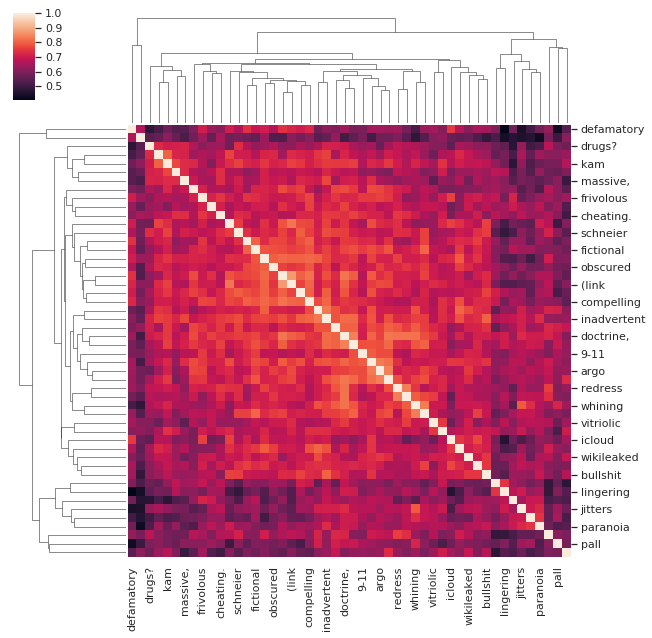

In [120]:
sns.clustermap(calWordMatrix(info_vocab))

### We can see that, the word 'misinformation' has similar words such as 'fabrication', 'frivalous', 'vitriolic', 'plagiarised', 'argo', 'dissenting', etc.